In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm import tqdm
from dft.main import Hamiltonian
from hamilton import Hamiltonian as HamOriginal
%config InlineBackend.figure_format = 'retina'

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.32.3792
https://journals.aps.org/prb/pdf/10.1103/PhysRevB.32.3780

In [2]:
def get_rho0(h):
    rho0b2 = 1.2**2
    rho0_G = (1./h.L) * np.exp(1j * h.Gvec_2 * h.pos) \
                  * np.exp(-0.5 * h.Gvec_2**2 * rho0b2)
    rho0 = np.fft.fft(rho0_G).real
    rho0 *= h.Nel
    return rho0

In [3]:
def scf_cycle(ham, rho_in):
    ham.computePot (rho_in)
    return ham.get_rho()

In [4]:
def run_scf(h, rho_i=None, pre_scale=0.8, max_steps=50):
    if rho_i is None:
        rho_i = get_rho0(h)
    allRes = []
    allE = []
    res_old=None
    search_old=None
    gamma = 0.
    for i in range(max_steps):
        h.rho = rho_i
        rho_o = h.get_rho()
        res = rho_o-rho_i
        allRes.append (np.linalg.norm(res))
        # h.rho = rho_o
        allE.append (h.e_tot)

        if allRes[-1] < 1e-10:
            break

        # conjugate-gradient for density (not sure this works in all cases!)
        # should be DIIS or MINRES
        search = res
        if search_old is not None:
            gamma = np.dot(res_old, res)/np.dot(res_old, res_old)
            search += gamma * search_old
        search_old = search
        res_old = res

        # line search
        rho_trial = rho_i + pre_scale * search
        h.rho = rho_trial
        resTrial = h.get_rho() - rho_trial
        step = -np.dot(resTrial-res, res) /np.dot(resTrial-res,resTrial-res)

        # optimal step
        rho_i = rho_i + step * pre_scale * search

        # dynamic adaptation of pre_scale
        if (step > 2):
            pre_scale *= 1.5
        elif (step < 0.5):
            pre_scale /= 1.5
    return allE, allRes

In [22]:
Npw = 150
L = 5
Nel = 7
E_lst = []
p_tot_lst = []
E_tot_lst = []
R_lst = []
L_lst = np.linspace(7.5, 8, 11)
for L in tqdm(L_lst):
    h = Hamiltonian(Npw, L, Nel)
    E, R = run_scf(h)
    E_lst.append(E[-1])
    R_lst.append(R[-1])
    E_tot_lst.append([h.e_kin, h.e_H, h.e_xc])
    p_kin = np.einsum(
            'j,ij,i->', h._focc_trunc, np.absolute(h._vecs_trunc)**2, h.Gvec**2,
            optimize=True
        ) / h.L
    p_el = 0.5 * np.vdot(h.rho_G, h.v_G).real
    p_xc = (h.e_xc - np.sum(h.rho*h.v_xc) * h._dL / 2) / h.L
    p_tot_lst.append([p_kin, p_el, p_xc])

p_tot_lst = np.array(p_tot_lst)
E_tot_lst = np.array(E_tot_lst)

100%|██████████| 11/11 [00:28<00:00,  2.63s/it]


In [33]:
def get_fit(L_lst, E_lst, derivative=False, order=3, n_points=100):
    coeff = np.polyfit(L_lst, E_lst, order)
    L = np.linspace(L_lst.min(), L_lst.max(), n_points)
    if derivative:
        return L, np.polyval(np.polyder(coeff), L)
    return L, np.polyval(coeff, L)

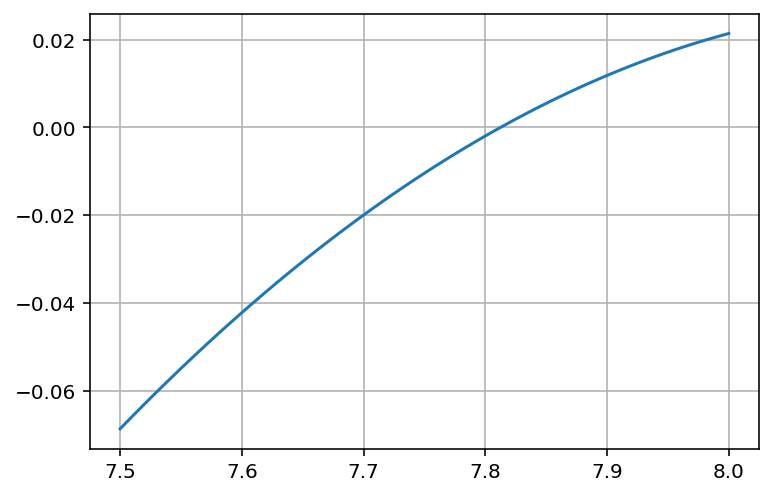

In [43]:
plt.grid()
# plt.plot(*get_fit(L_lst, np.sum(p_tot_lst, axis=-1)))
plt.plot(*get_fit(L_lst, E_lst, derivative=True))